## Load Libraries

In [1]:
import numpy as np
import MDAnalysis as md
import matplotlib.pyplot as plt
%matplotlib inline
from shapeGMMTorch import torch_sgmm, scripts, torch_align
import torch

## Load Trajectory

In [3]:
# point to parameter/topology file and trajectory file
parm_file = "idp_14_19_vac.parm7"
traj_file = "idp_14_19_solv.nvt.stripped.dcd"
# create MD Universe
coord = md.Universe(parm_file,traj_file)
print(coord.trajectory.n_frames)
# make atom selection
sel = coord.select_atoms("all")
# create empty array to contain all selection coordinates
traj_data = np.empty((coord.trajectory.n_frames,sel.n_atoms,3),dtype=np.float64)
# read trajectory and store coordinates (minus COG)
for ts in coord.trajectory:
    traj_data[ts.frame] = sel.positions-sel.center_of_geometry()

30000


## Align Trajectory to single average

In [6]:
ksgmm1 = torch_sgmm.ShapeGMMTorch(1,covar_type="kronecker",kabsch_thresh=1e-3,dtype=torch.float64,device=torch.device("cpu"),verbose=True)
aligned_traj_ksgmm1 = ksgmm1.fit(traj_data)

Number of frames being analyzed: 30000
Number of particles being analyzed: 109
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Setting uniform frame weights
550.4502085538816
552.8159273539441
554.2555988756544
555.2844900848386
556.1486920361016
557.0721436055456
557.9428062549789
558.6429110552833
559.212517797394
559.7122195528002
560.176745085
560.626619410713
561.0777442852694
561.5443321460094
562.0382561142467
562.566531487209
563.128218764295
563.7124109918749
564.298963012515
564.862512472407
565.3785407902106
565.8290794593266
566.2059706395419
566.510823252781
566.7522357397561
566.9419486463587
567.0916565392906
567.2112704111993
567.3084387210522
567.3887624609399
567.4562429340567
567.513721944225
567.5632319624069
567.6062494843441
567.643870086784
567.6769268418996
567.7060698036335
567.7318193494772
567.7546021169744
567.7747753702922
567.7926436654221
567.8084703751063
567.8224857750255
567.834892825613
567.8458714053327
567.8555815018

In [4]:
usgmm1 = torch_sgmm.ShapeGMMTorch(1,covar_type="uniform",kabsch_thresh=1e-3,dtype=torch.float64,device=torch.device("cpu"),verbose=True)
aligned_traj_usgmm1 = usgmm1.fit(traj_data)

Number of frames being analyzed: 30000
Number of particles being analyzed: 109
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Setting uniform frame weights
Weights from initial clusters in fit: [1.]
1 [1.] -327.945
2 [1.] -327.945


In [5]:
dtype = torch.float64
device = torch.device("cpu")
traj_data_tensor = torch.tensor(traj_data,dtype=dtype,device=device)
torch_align.torch_remove_center_of_geometry(traj_data_tensor,dtype=dtype,device=device)
aligned_traj_tensor, avg_tensor = torch_align.torch_iterative_align_uniform(traj_data_tensor,dtype=dtype,device=device,verbose=True)[:2]

-332.8261507481754
-328.04669961123693
-327.94715529870257
-327.9447539824331
-327.9446947302745


In [7]:
aligned_traj = aligned_traj_tensor.cpu().numpy()
aligned_avg = avg_tensor.cpu().numpy()
print(np.linalg.norm(aligned_traj_usgmm1-aligned_traj))

1.1271106724880442


## Compute Covariance Matrix

In [8]:
disp = aligned_traj - aligned_avg
disp = disp.reshape(-1,sel.n_atoms*3)
covar = np.dot(disp.T,disp)
covar /= (disp.shape[0]-1)

In [9]:
print(covar.shape)

(327, 327)


In [13]:
# check covariance matrix has a null space of 6
e, v = np.linalg.eigh(covar)
print(e[:10])

[-1.86097612e-16 -8.59441376e-17  2.12437659e-16  5.22839848e-16
  5.45472346e-16  2.21760410e-15  2.87385876e-04  2.89530920e-04
  3.02601038e-04  3.04284293e-04]


In [7]:
np.savetxt("idp_14_19_uniform_covar.dat",covar)

In [8]:
np.savetxt("idp_14_19_uniform_avg.dat", avg_tensor.cpu().numpy())

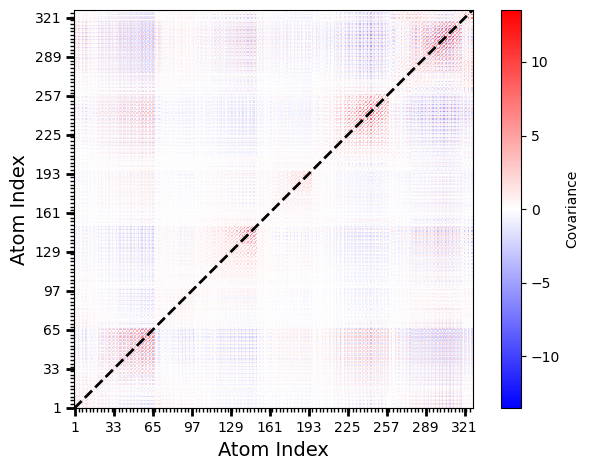

In [23]:
#plot covariance matrix
from matplotlib.ticker import MultipleLocator
plotting_cmap='bwr'
n_nodes = covar.shape[0]
node_range = range(n_nodes+1)
major_ticks = n_nodes//10
minor_ticks = n_nodes//100
fig, ax = plt.subplots()
ax.tick_params(which='major',length=6,width=2)
ax.tick_params(which='minor',length=3,width=1)
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))
ax.yaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.yaxis.set_major_locator(MultipleLocator(major_ticks))
# make vrange symmetric about zero
v_min = min(np.amin(covar),-np.amax(covar))
v_max = max(np.amax(covar),-np.amin(covar))
temp = plt.pcolormesh(node_range,node_range,covar,cmap=plotting_cmap,vmin=v_min,vmax=v_max)

cb1 = plt.colorbar()
cb1.set_label(r'%s'%("Covariance"))

xlabels = [str(int(x)+1) for x in temp.axes.get_xticks()[:]]
ylabels = [str(int(y)+1) for y in temp.axes.get_yticks()[:]]
temp.axes.set_xticks(temp.axes.get_xticks(minor=True)[:]+0.5,minor=True)
temp.axes.set_xticks(temp.axes.get_xticks()[:]+0.5)
temp.axes.set_yticks(temp.axes.get_yticks(minor=True)[:]+0.5,minor=True)
temp.axes.set_yticks(temp.axes.get_yticks()[:]+0.5)
temp.axes.set_xticklabels(xlabels)
temp.axes.set_yticklabels(ylabels)

plt.xlim((0,n_nodes))
plt.ylim((0,n_nodes))
plt.xlabel("Atom Index",size=14)
plt.ylabel("Atom Index",size=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.plot(np.arange(0,n_nodes,0.01),np.arange(0,n_nodes,0.01),'--',lw=2,color='k')
plt.show();

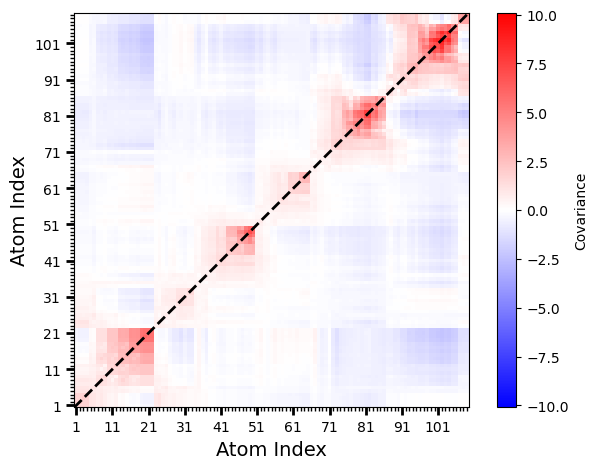

In [22]:
#plot NxN covariance matrix
disp = aligned_traj - avg_tensor.cpu().numpy()
disp = np.transpose(disp,(1,0,2))
disp = disp.reshape(-1,disp.shape[1]*disp.shape[2])
covarN = np.dot(disp,disp.T)
covarN /= (3*(aligned_traj.shape[0]-1))

from matplotlib.ticker import MultipleLocator
plotting_cmap='bwr'
n_nodes = covarN.shape[0]
node_range = range(n_nodes+1)
major_ticks = n_nodes//10
minor_ticks = n_nodes//100
fig, ax = plt.subplots()
ax.tick_params(which='major',length=6,width=2)
ax.tick_params(which='minor',length=3,width=1)
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))
ax.yaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.yaxis.set_major_locator(MultipleLocator(major_ticks))
# make vrange symmetric about zero
v_min = min(np.amin(covarN),-np.amax(covarN))
v_max = max(np.amax(covarN),-np.amin(covarN))
temp = plt.pcolormesh(node_range,node_range,covarN,cmap=plotting_cmap,vmin=v_min,vmax=v_max)

cb1 = plt.colorbar()
cb1.set_label(r'%s'%("Covariance"))

xlabels = [str(int(x)+1) for x in temp.axes.get_xticks()[:]]
ylabels = [str(int(y)+1) for y in temp.axes.get_yticks()[:]]
temp.axes.set_xticks(temp.axes.get_xticks(minor=True)[:]+0.5,minor=True)
temp.axes.set_xticks(temp.axes.get_xticks()[:]+0.5)
temp.axes.set_yticks(temp.axes.get_yticks(minor=True)[:]+0.5,minor=True)
temp.axes.set_yticks(temp.axes.get_yticks()[:]+0.5)
temp.axes.set_xticklabels(xlabels)
temp.axes.set_yticklabels(ylabels)

plt.xlim((0,n_nodes))
plt.ylim((0,n_nodes))
plt.xlabel("Atom Index",size=14)
plt.ylabel("Atom Index",size=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.plot(np.arange(0,n_nodes,0.01),np.arange(0,n_nodes,0.01),'--',lw=2,color='k')
plt.show();

## Perform cluster scan

In [9]:
# define cluster array
cluster_array = np.arange(1,6,1).astype(int)
print(cluster_array)

[1 2 3 4 5]


In [11]:
# perform cluster scan
train, cv = scripts.cross_validate_cluster_scan(traj_data, 25000, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 5, dtype=dtype, device=device)

Number of frames to train each model: 25000
Number of frames to predict each model: 5000
Number of training sets: 3
Number of clusters: 5
Number of attempts per set/cluster: 5
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1             405.849         227.648
              1               2               1             424.638         303.871
              1               2               2             424.625         306.041
              1               2               3             424.575         336.530
              1               2               4             424.591         314.221
              1               2               5             424.599         382.668
              1               3               1             428.226         308.069
              1               3               2             428.184

In [24]:
np.savetxt("train.dat",train)
np.savetxt("cv.dat",cv)

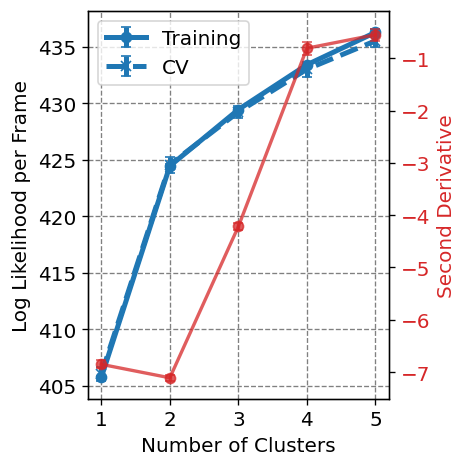

In [12]:
# shapeGMMTorch plots has a built-in plot function for this type of plot
from shapeGMMTorch import plots
# also need to load matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# create figure
fig, ax = plt.subplots(1,1,figsize=(4,4), dpi= 120, facecolor='w', edgecolor='k',sharex=True,sharey=True)
plots.plot_log_likelihood_with_dd(ax,cluster_array,train,cv,fontsize=12,ylabel1=True,ylabel2=True,xlabel=True)
# show plot
plt.tight_layout()
plt.show()